In [147]:
# Q1:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
import os
import glob
import pandas as pd

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

In [148]:
# Load the data file:

data = pd.read_csv('BaynesSoundMooring_5m_CO2PartialPressure_20210923T000000Z_20210925T235959Z_RAW.csv', header=52, usecols=[0,1,2])



In [149]:
# Drop the "end header" row of the dataframe:
data = data.drop([0])

In [150]:

# Need to convert the dates to date time:
data['Datetime'] = pd.to_datetime(data['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])

# Drop the older date column:
data.drop(columns='#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"', inplace = True)


,"""CO2 Partial Pressure (pCO2 uatm)""","""CO2 Partial Pressure QC Flag""",Datetime
1,614.194621,1.0,2021-09-23 00:00:00.207000+00:00
2,614.204441,1.0,2021-09-23 00:00:00.236000+00:00
3,446.284086,1.0,2021-09-23 00:00:53.163000+00:00
4,448.472865,1.0,2021-09-23 00:00:54.237000+00:00
5,450.003691,1.0,2021-09-23 00:00:55.299000+00:00
...,...,...,...
239038,844.041806,1.0,2021-09-25 23:59:55.562000+00:00
239039,844.061466,1.0,2021-09-25 23:59:56.637000+00:00
239040,844.071295,1.0,2021-09-25 23:59:57.712000+00:00
239041,843.894360,1.0,2021-09-25 23:59:58.801000+00:00


In [151]:
# Extract the data from 12:30 to 14:30 during 24-Sept-2021 and plot the pCO2 data versus time.

# Create time boundaries to index by:
time_min = pd.to_datetime('2021-09-24T12:30:00.00Z')
time_max = pd.to_datetime('2021-09-24T14:30:00.00Z')


# Index out the above time range:
df_Sept24 = data[(data['Datetime'] >= time_min) & (data['Datetime'] <= time_max)]


# Rename some columns:
df_Sept24.columns = ['pCO2', 'pCO2_flag', 'Datetime']


,pCO2,pCO2_flag,Datetime
121794,637.725201,1.0,2021-09-24 12:30:00.675000+00:00
121795,637.607007,1.0,2021-09-24 12:30:01.741000+00:00
121796,637.065285,1.0,2021-09-24 12:30:03.572000+00:00
121797,637.291823,1.0,2021-09-24 12:30:04.651000+00:00
121798,637.380469,1.0,2021-09-24 12:30:05.718000+00:00
...,...,...,...
128420,576.727283,1.0,2021-09-24 14:29:55.332000+00:00
128421,576.717434,1.0,2021-09-24 14:29:56.399000+00:00
128422,576.737133,1.0,2021-09-24 14:29:57.467000+00:00
128423,576.855327,1.0,2021-09-24 14:29:58.533000+00:00


In [153]:

# Create a function to calculate the outlier factor metric for each K value:

def LOF (x, k):
    
    clf = LocalOutlierFactor(n_neighbors=k, contamination=0.1)
    clf.fit_predict(x)
    estimate = clf.negative_outlier_factor_
    
    return estimate



In [154]:
# Derive all outlier estimates for each K value using the above function:

pCO2 = np.array(df_Sept24['pCO2']).reshape(-1, 1)  # reshape for input


estimate_10 = LOF(pCO2, 10)
estimate_100 = LOF(pCO2, 100)
estimate_1000 = LOF(pCO2, 1000)
estimate_2000 = LOF(pCO2, 2000)


In [155]:
# Create a function to reshape the outlier estimates:


def reshape_out (x):
    
    outlier_array = np.array(x)
    
    reshaped_outlier_array = outlier_array.reshape(-1, 1)
    reshaped_outlier_df = pd.DataFrame(reshaped_outlier_array)
    
    return reshaped_outlier_df
    



In [156]:
# Apply the reshape funciton to all estimates:
outlier_estimate_k10 = reshape_out(estimate_10)
outlier_estimate_k100 = reshape_out(estimate_100)
outlier_estimate_k1000 = reshape_out(estimate_1000)
outlier_estimate_k2000 = reshape_out(estimate_2000)


# Merge all estimates from different Ks into a dataframe:
outlier_df = pd.concat([outlier_estimate_k10, outlier_estimate_k100, 
                        outlier_estimate_k1000, outlier_estimate_k2000], axis = 1)

outlier_df.columns = ['K10', 'K100', 'K1000', 'K2000']


           K10      K100     K1000     K2000
0    -1.158972 -0.994080 -0.979236 -1.025642
1    -1.300290 -0.990599 -0.978390 -1.025469
2    -1.009266 -0.970777 -0.975986 -1.024501
3    -1.063705 -0.945889 -0.976320 -1.024986
4    -0.979865 -0.952124 -0.976858 -1.025133
...        ...       ...       ...       ...
6626 -1.086218 -1.228309 -0.993136 -0.992325
6627 -0.980735 -1.244767 -0.993137 -0.992325
6628 -1.044048 -1.211304 -0.993135 -0.992324
6629 -1.184156 -1.074227 -0.993124 -0.992322
6630 -1.000000 -0.998593 -0.993337 -0.992291

[6631 rows x 4 columns]


In [157]:
# Merge outlier estimate array with the Sept 24th data:

df_Sept24 = df_Sept24.reset_index()  # Reset the index to concatenate dataframes

df_Sept24_new = pd.concat([df_Sept24, outlier_df], axis=1)  # Concatenate the dataframes


In [160]:

# Remove all values outside the outlier threshold:

# K10:
df_Sept24_K10_OUTLIERS = df_Sept24_new[(df_Sept24_new['K10'] <= Outlier_threshold)]  # outlier df
df_Sept24_K10_cleaned = df_Sept24_new[(df_Sept24_new['K10'] >= Outlier_threshold)]  # outlier removed df


# K100:
df_Sept24_K100_OUTLIERS = df_Sept24_new[(df_Sept24_new['K100'] <= Outlier_threshold)]  # outlier df
df_Sept24_K100_cleaned = df_Sept24_new[(df_Sept24_new['K100'] >= Outlier_threshold)]  # outlier removed df


# K1000:
df_Sept24_K1000_OUTLIERS = df_Sept24_new[(df_Sept24_new['K1000'] <= Outlier_threshold)]  # outlier df
df_Sept24_K1000_cleaned = df_Sept24_new[(df_Sept24_new['K1000'] >= Outlier_threshold)]  # outlier removed df


# K2000:
df_Sept24_K2000_OUTLIERS = df_Sept24_new[(df_Sept24_new['K2000'] <= Outlier_threshold)]  # outlier df
df_Sept24_K2000_cleaned = df_Sept24_new[(df_Sept24_new['K2000'] >= Outlier_threshold)]  # outlier removed df




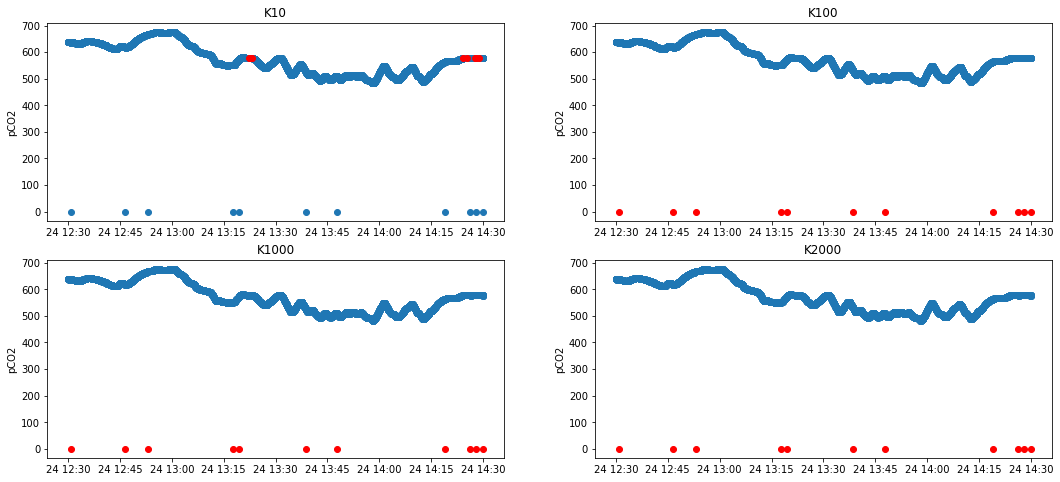

In [161]:

# Visualize the suspected outliers as predicted by LOF

fig, axs = plt.subplots(2,2, figsize = (18, 8))

axs[0, 0].scatter(df_Sept24_K10_cleaned["Datetime"], df_Sept24_K10_cleaned["pCO2"]) 
axs[0, 0].scatter(df_Sept24_K10_OUTLIERS["Datetime"], df_Sept24_K10_OUTLIERS["pCO2"], color = 'r') 
axs[0, 0].set_ylabel('pCO2')
axs[0, 0].set_title('K10')

axs[0, 1].scatter(df_Sept24_K100_cleaned["Datetime"], df_Sept24_K100_cleaned["pCO2"]) 
axs[0, 1].scatter(df_Sept24_K100_OUTLIERS["Datetime"], df_Sept24_K100_OUTLIERS["pCO2"], color = 'r') 
axs[0, 1].set_ylabel('pCO2')
axs[0, 1].set_title('K100')

axs[1, 0].scatter(df_Sept24_K1000_cleaned["Datetime"], df_Sept24_K1000_cleaned["pCO2"])
axs[1, 0].scatter(df_Sept24_K1000_OUTLIERS["Datetime"], df_Sept24_K1000_OUTLIERS["pCO2"], color = 'r') 
axs[1, 0].set_ylabel('pCO2')
axs[1, 0].set_title('K1000')

axs[1, 1].scatter(df_Sept24_K2000_cleaned["Datetime"], df_Sept24_K2000_cleaned["pCO2"])
axs[1, 1].scatter(df_Sept24_K2000_OUTLIERS["Datetime"], df_Sept24_K2000_OUTLIERS["pCO2"], color = 'r') 
axs[1, 1].set_ylabel('pCO2')
axs[1, 1].set_title('K2000')

plt.show()

